# Data Quality Analysis: Missing Data & Channel Health

This notebook analyzes data quality issues in the IQ data including:
- Missing or zero samples per channel
- Signal dropouts and gaps
- Power variations across channels
- Data integrity checks

## 1. Setup and Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft
import os
from glob import glob

# Import shared constants
from constants import CHANNEL_ORDER, RADIUS, C, DATA_DIR

# Plot settings
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 12

print("Setup complete!")
print(f"Using channel order: {CHANNEL_ORDER}")

Setup complete!
Using channel order: [2, 3, 0, 1]


## 2. Data Loading Functions

In [2]:
def load_cs16(filepath):
    """Load a .cs16 file and return complex IQ samples."""
    raw = np.fromfile(filepath, dtype=np.int16)
    # Interleaved I, Q -> complex
    iq = raw[0::2] + 1j * raw[1::2]
    return iq

def load_cs16_raw(filepath):
    """Load a .cs16 file and return raw I and Q separately."""
    raw = np.fromfile(filepath, dtype=np.int16)
    I = raw[0::2]
    Q = raw[1::2]
    return I, Q

def load_measurement(base_dir, angle, channel_order=None):
    """Load all 4 channels for a given angle measurement.
    
    Args:
        base_dir: Base data directory
        angle: Measurement angle in degrees
        channel_order: List specifying channel reordering. If None, uses CHANNEL_ORDER from constants.
    """
    if channel_order is None:
        channel_order = CHANNEL_ORDER
        
    data_dir = os.path.join(base_dir, f"{angle}deg")
    channels = []
    for i in range(4):
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        channels.append(load_cs16(filepath))
    
    raw_data = np.vstack(channels)  # Shape: (4, num_samples)
    return raw_data[channel_order]

def load_measurement_raw(base_dir, angle, channel_order=None):
    """Load all 4 channels raw I/Q for a given angle measurement."""
    if channel_order is None:
        channel_order = CHANNEL_ORDER
        
    data_dir = os.path.join(base_dir, f"{angle}deg")
    I_channels = []
    Q_channels = []
    for i in range(4):
        filepath = os.path.join(data_dir, f"channel-{i}.cs16")
        I, Q = load_cs16_raw(filepath)
        I_channels.append(I)
        Q_channels.append(Q)
    
    I_raw = np.vstack(I_channels)
    Q_raw = np.vstack(Q_channels)
    return I_raw[channel_order], Q_raw[channel_order]

# Data directory (from constants.py)
DATA_PATH = f"../data/{DATA_DIR}"

# List available angles
angle_dirs = sorted(glob(os.path.join(DATA_PATH, "*deg")))
available_angles = [int(os.path.basename(d).replace('deg', '')) for d in angle_dirs]
print(f"Found {len(available_angles)} angle measurements")
print(f"Angles: {available_angles[:10]}... (showing first 10)")
print(f"Channel order: {CHANNEL_ORDER}")

Found 360 angle measurements
Angles: [0, 100, 101, 102, 103, 104, 105, 106, 107, 108]... (showing first 10)
Channel order: [2, 3, 0, 1]


## 3. Basic Data Statistics Per Channel

In [3]:
# Load a sample measurement
test_angle = 45
X = load_measurement(DATA_PATH, test_angle)
I_raw, Q_raw = load_measurement_raw(DATA_PATH, test_angle)

print(f"=" * 60)
print(f"DATA STATISTICS FOR {test_angle}° MEASUREMENT")
print(f"=" * 60)

for ch in range(4):
    iq = X[ch]
    I, Q = I_raw[ch], Q_raw[ch]
    
    print(f"\nChannel {ch}:")
    print(f"  Samples: {len(iq):,}")
    print(f"  I range: [{I.min()}, {I.max()}]")
    print(f"  Q range: [{Q.min()}, {Q.max()}]")
    print(f"  Mean magnitude: {np.mean(np.abs(iq)):.2f}")
    print(f"  Max magnitude: {np.max(np.abs(iq)):.2f}")
    print(f"  Power (dB): {10*np.log10(np.mean(np.abs(iq)**2)):.2f} dB")

DATA STATISTICS FOR 45° MEASUREMENT

Channel 0:
  Samples: 2,097,152
  I range: [-503, 504]
  Q range: [-473, 504]
  Mean magnitude: 213.77
  Max magnitude: 542.03
  Power (dB): 46.67 dB

Channel 1:
  Samples: 2,097,152
  I range: [-675, 675]
  Q range: [-684, 674]
  Mean magnitude: 349.55
  Max magnitude: 692.63
  Power (dB): 50.94 dB

Channel 2:
  Samples: 2,097,152
  I range: [-260, 268]
  Q range: [-271, 263]
  Mean magnitude: 223.19
  Max magnitude: 276.52
  Power (dB): 46.98 dB

Channel 3:
  Samples: 2,097,152
  I range: [-125, 131]
  Q range: [-128, 124]
  Mean magnitude: 88.83
  Max magnitude: 134.62
  Power (dB): 39.01 dB


## 4. Missing/Zero Sample Detection

In [4]:
def analyze_missing_data(X, I_raw, Q_raw):
    """Analyze missing or zero samples in the data."""
    results = []
    
    for ch in range(4):
        iq = X[ch]
        I, Q = I_raw[ch], Q_raw[ch]
        
        # Count zeros
        zero_iq = np.sum(iq == 0)
        zero_I = np.sum(I == 0)
        zero_Q = np.sum(Q == 0)
        zero_both = np.sum((I == 0) & (Q == 0))
        
        # Count very low magnitude samples (potential dropouts)
        threshold = np.mean(np.abs(iq)) * 0.01  # 1% of mean
        low_mag = np.sum(np.abs(iq) < threshold)
        
        # Count NaN or Inf (shouldn't happen with int16 but check anyway)
        nan_count = np.sum(np.isnan(iq))
        inf_count = np.sum(np.isinf(iq))
        
        results.append({
            'channel': ch,
            'total_samples': len(iq),
            'zero_iq': zero_iq,
            'zero_I': zero_I,
            'zero_Q': zero_Q,
            'zero_both': zero_both,
            'low_magnitude': low_mag,
            'nan': nan_count,
            'inf': inf_count
        })
    
    return results

missing_data = analyze_missing_data(X, I_raw, Q_raw)

print(f"\n{'='*70}")
print("MISSING/ZERO DATA ANALYSIS")
print(f"{'='*70}")
print(f"{'Channel':<10} {'Zero IQ':<12} {'Zero I':<12} {'Zero Q':<12} {'Zero Both':<12} {'Low Mag':<12}")
print("-" * 70)

for r in missing_data:
    pct_zero = r['zero_both'] / r['total_samples'] * 100
    pct_low = r['low_magnitude'] / r['total_samples'] * 100
    print(f"Ch {r['channel']:<7} {r['zero_iq']:<12} {r['zero_I']:<12} {r['zero_Q']:<12} {r['zero_both']:<12} {r['low_magnitude']:<12}")
    print(f"          ({r['zero_iq']/r['total_samples']*100:.4f}%)    ({r['zero_I']/r['total_samples']*100:.4f}%)    ({r['zero_Q']/r['total_samples']*100:.4f}%)    ({pct_zero:.4f}%)      ({pct_low:.4f}%)")


MISSING/ZERO DATA ANALYSIS
Channel    Zero IQ      Zero I       Zero Q       Zero Both    Low Mag     
----------------------------------------------------------------------
Ch 0       169          3706         3815         169          1943        
          (0.0081%)    (0.1767%)    (0.1819%)    (0.0081%)      (0.0926%)
Ch 1       167          2833         2669         167          4930        
          (0.0080%)    (0.1351%)    (0.1273%)    (0.0080%)      (0.2351%)
Ch 2       0            1481         1621         0            0           
          (0.0000%)    (0.0706%)    (0.0773%)    (0.0000%)      (0.0000%)
Ch 3       0            5274         5204         0            0           
          (0.0000%)    (0.2515%)    (0.2481%)    (0.0000%)      (0.0000%)


## 5. Visualize Sample Distribution Per Channel

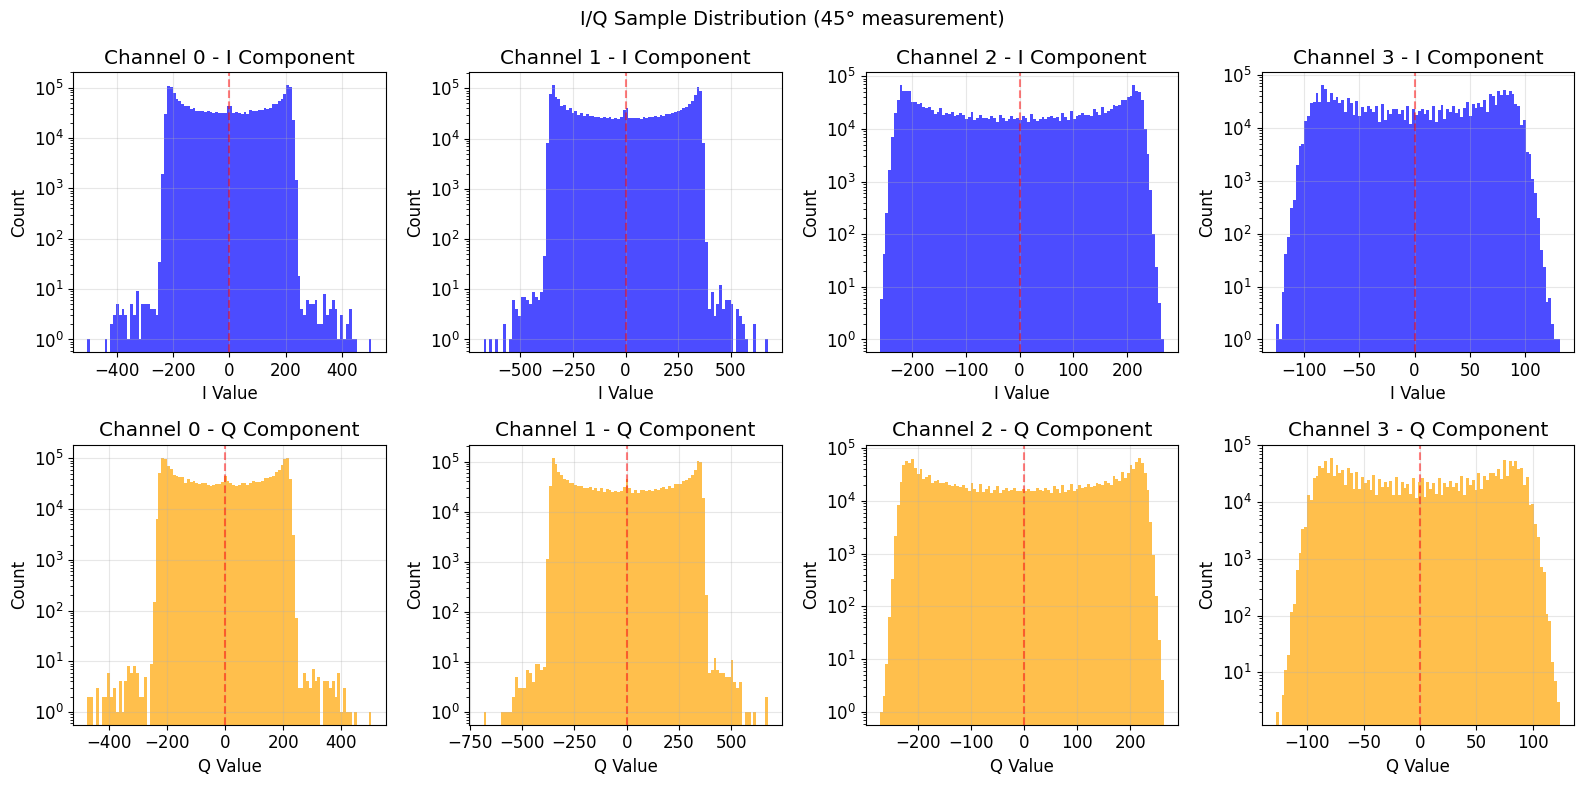

In [5]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

for ch in range(4):
    I, Q = I_raw[ch], Q_raw[ch]
    
    # I histogram
    ax = axes[0, ch]
    ax.hist(I, bins=100, alpha=0.7, color='blue', edgecolor='none')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('I Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Channel {ch} - I Component')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)
    
    # Q histogram
    ax = axes[1, ch]
    ax.hist(Q, bins=100, alpha=0.7, color='orange', edgecolor='none')
    ax.axvline(0, color='red', linestyle='--', alpha=0.5)
    ax.set_xlabel('Q Value')
    ax.set_ylabel('Count')
    ax.set_title(f'Channel {ch} - Q Component')
    ax.set_yscale('log')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'I/Q Sample Distribution ({test_angle}° measurement)', fontsize=14)
plt.tight_layout()
plt.show()

## 6. Signal Power Over Time (Dropout Detection)

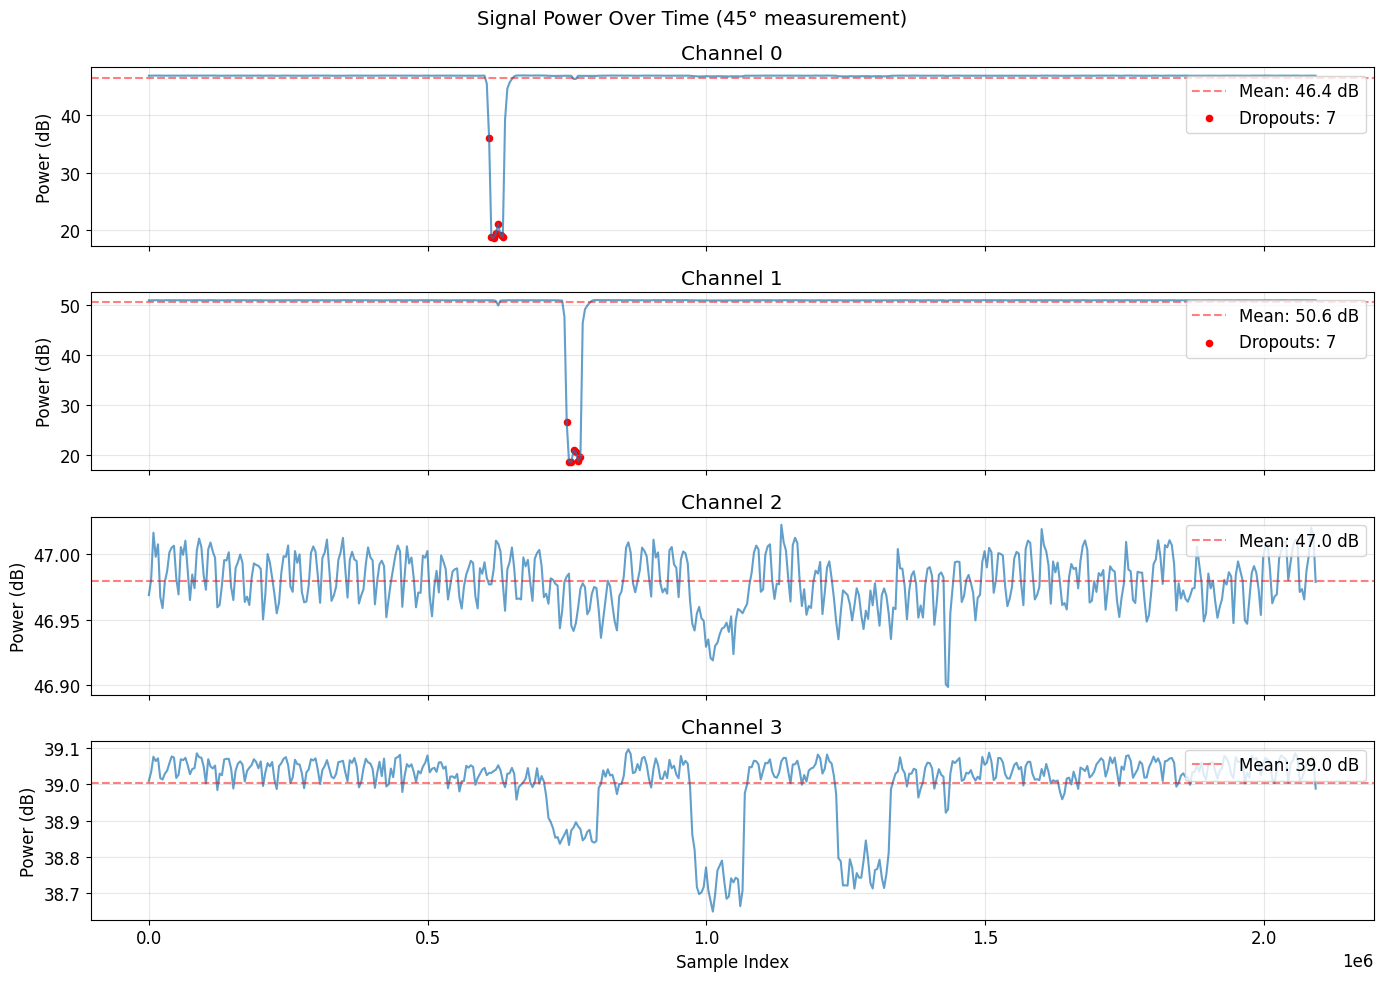

In [6]:
def compute_windowed_power(iq, window_size=1024):
    """Compute power in sliding windows."""
    n_windows = len(iq) // window_size
    powers = []
    for i in range(n_windows):
        segment = iq[i*window_size:(i+1)*window_size]
        power = np.mean(np.abs(segment)**2)
        powers.append(10 * np.log10(power) if power > 0 else -100)
    return np.array(powers)

fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

window_size = 4096
for ch in range(4):
    powers = compute_windowed_power(X[ch], window_size)
    time_axis = np.arange(len(powers)) * window_size
    
    ax = axes[ch]
    ax.plot(time_axis, powers, alpha=0.7)
    ax.axhline(np.mean(powers), color='r', linestyle='--', alpha=0.5, 
               label=f'Mean: {np.mean(powers):.1f} dB')
    ax.set_ylabel('Power (dB)')
    ax.set_title(f'Channel {ch}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    
    # Mark potential dropouts (>10dB below mean)
    dropout_thresh = np.mean(powers) - 10
    dropouts = powers < dropout_thresh
    if np.any(dropouts):
        ax.scatter(time_axis[dropouts], powers[dropouts], color='red', s=20, 
                   label=f'Dropouts: {np.sum(dropouts)}')
        ax.legend(loc='upper right')

axes[-1].set_xlabel('Sample Index')
plt.suptitle(f'Signal Power Over Time ({test_angle}° measurement)', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Power Comparison Across Channels

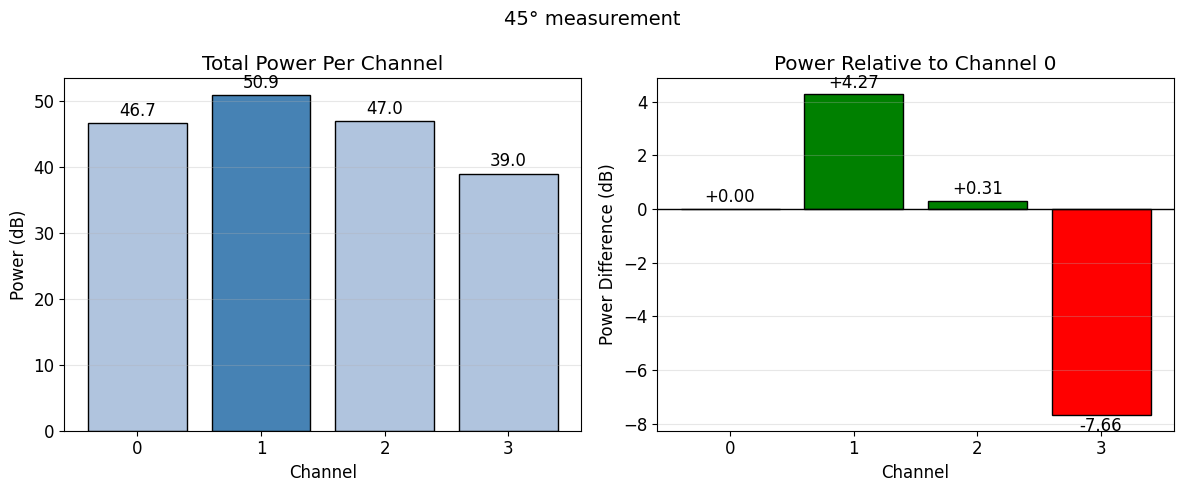


Power imbalance (max - min): 11.93 dB


In [7]:
# Compute power for each channel
channel_powers = []
for ch in range(4):
    power = np.mean(np.abs(X[ch])**2)
    power_db = 10 * np.log10(power)
    channel_powers.append(power_db)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar chart
ax = axes[0]
colors = ['steelblue' if p == max(channel_powers) else 'lightsteelblue' for p in channel_powers]
bars = ax.bar(range(4), channel_powers, color=colors, edgecolor='black')
ax.set_xlabel('Channel')
ax.set_ylabel('Power (dB)')
ax.set_title('Total Power Per Channel')
ax.set_xticks(range(4))
ax.grid(True, alpha=0.3, axis='y')

# Add value labels
for i, (bar, power) in enumerate(zip(bars, channel_powers)):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
            f'{power:.1f}', ha='center', va='bottom')

# Power difference from reference (Ch 0)
ax = axes[1]
power_diff = [p - channel_powers[0] for p in channel_powers]
colors = ['green' if d >= 0 else 'red' for d in power_diff]
bars = ax.bar(range(4), power_diff, color=colors, edgecolor='black')
ax.axhline(0, color='black', linewidth=1)
ax.set_xlabel('Channel')
ax.set_ylabel('Power Difference (dB)')
ax.set_title('Power Relative to Channel 0')
ax.set_xticks(range(4))
ax.grid(True, alpha=0.3, axis='y')

for i, (bar, diff) in enumerate(zip(bars, power_diff)):
    va = 'bottom' if diff >= 0 else 'top'
    offset = 0.1 if diff >= 0 else -0.1
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + offset, 
            f'{diff:+.2f}', ha='center', va=va)

plt.suptitle(f'{test_angle}° measurement', fontsize=14)
plt.tight_layout()
plt.show()

print(f"\nPower imbalance (max - min): {max(channel_powers) - min(channel_powers):.2f} dB")

## 8. Data Quality Across All Angles

In [8]:
# Analyze data quality across all available angles
test_angles = available_angles[::5]  # Every 5th angle for speed

quality_data = {
    'angle': [],
    'power_ch0': [], 'power_ch1': [], 'power_ch2': [], 'power_ch3': [],
    'zero_ch0': [], 'zero_ch1': [], 'zero_ch2': [], 'zero_ch3': [],
    'sample_count': []
}

print(f"Analyzing {len(test_angles)} angles...")

for angle in test_angles:
    try:
        X = load_measurement(DATA_PATH, angle)
        I_raw, Q_raw = load_measurement_raw(DATA_PATH, angle)
        
        quality_data['angle'].append(angle)
        quality_data['sample_count'].append(X.shape[1])
        
        for ch in range(4):
            power = 10 * np.log10(np.mean(np.abs(X[ch])**2))
            zero_count = np.sum((I_raw[ch] == 0) & (Q_raw[ch] == 0))
            
            quality_data[f'power_ch{ch}'].append(power)
            quality_data[f'zero_ch{ch}'].append(zero_count)
            
    except Exception as e:
        print(f"  Error at {angle}°: {e}")

print(f"Done! Analyzed {len(quality_data['angle'])} angles.")

Analyzing 72 angles...
Done! Analyzed 72 angles.


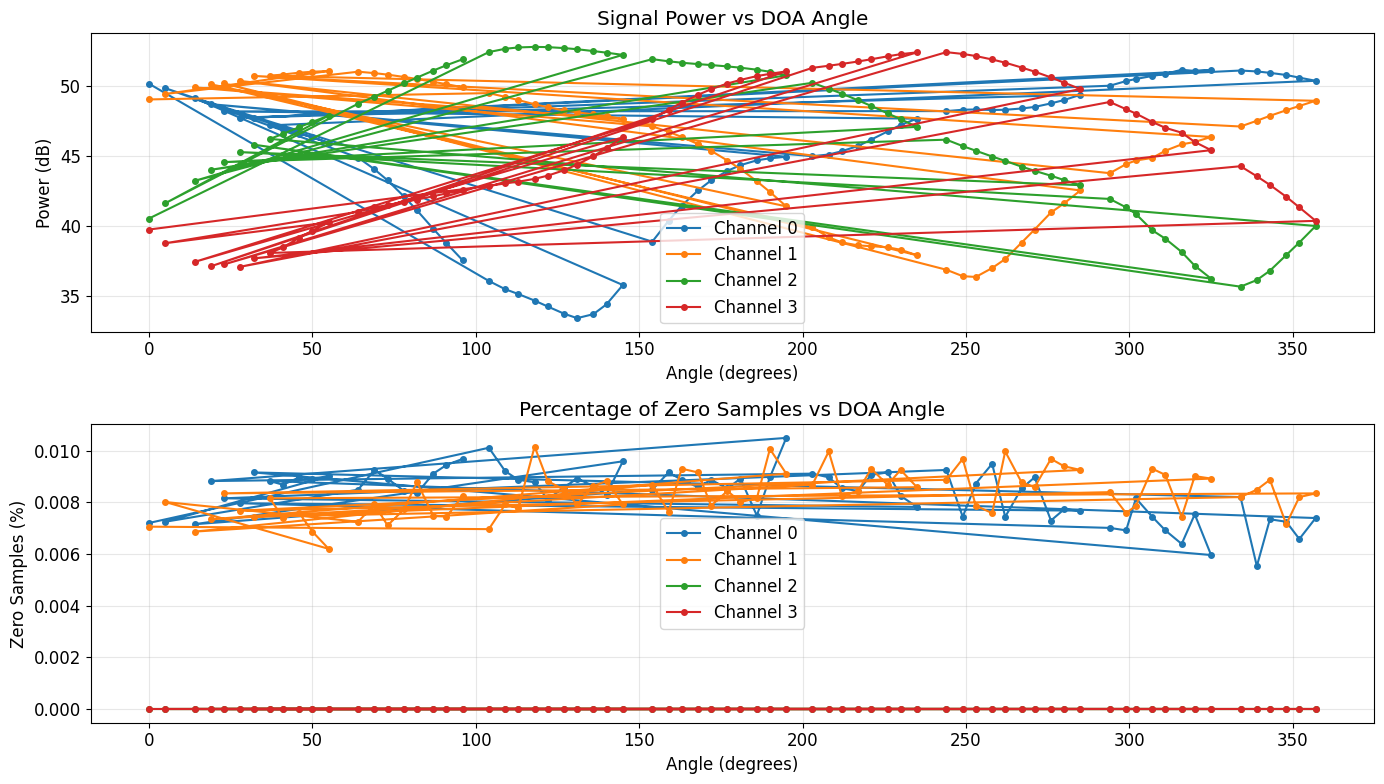

In [9]:
# Plot power across angles for each channel
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Power vs angle
ax = axes[0]
for ch in range(4):
    ax.plot(quality_data['angle'], quality_data[f'power_ch{ch}'], 
            'o-', markersize=4, label=f'Channel {ch}')
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Power (dB)')
ax.set_title('Signal Power vs DOA Angle')
ax.legend()
ax.grid(True, alpha=0.3)

# Zero count vs angle
ax = axes[1]
for ch in range(4):
    zeros_pct = [z / quality_data['sample_count'][i] * 100 
                 for i, z in enumerate(quality_data[f'zero_ch{ch}'])]
    ax.plot(quality_data['angle'], zeros_pct, 
            'o-', markersize=4, label=f'Channel {ch}')
ax.set_xlabel('Angle (degrees)')
ax.set_ylabel('Zero Samples (%)')
ax.set_title('Percentage of Zero Samples vs DOA Angle')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Missing Data Inventory Per Measurement

A comprehensive table showing missing/problematic data for each angle measurement.

In [ ]:
# Comprehensive missing data inventory for ALL measurements
print("Scanning all measurements for missing data...")
print("=" * 90)

# Thresholds for flagging issues
ZERO_THRESHOLD = 0.01  # Flag if >0.01% zeros
LOW_POWER_THRESHOLD = 30  # Flag if power < 30 dB
POWER_IMBALANCE_THRESHOLD = 6  # Flag if channel differs >6 dB from mean

inventory = []

for angle in available_angles:
    try:
        X = load_measurement(DATA_PATH, angle)
        I_raw, Q_raw = load_measurement_raw(DATA_PATH, angle)
        n_samples = X.shape[1]
        
        entry = {
            'angle': angle,
            'n_samples': n_samples,
            'channels': {}
        }
        
        powers = []
        for ch in range(4):
            zero_count = np.sum((I_raw[ch] == 0) & (Q_raw[ch] == 0))
            zero_pct = zero_count / n_samples * 100
            power = 10 * np.log10(np.mean(np.abs(X[ch])**2))
            powers.append(power)
            
            entry['channels'][ch] = {
                'zeros': zero_count,
                'zero_pct': zero_pct,
                'power_db': power
            }
        
        entry['mean_power'] = np.mean(powers)
        entry['power_imbalance'] = max(powers) - min(powers)
        inventory.append(entry)
        
    except Exception as e:
        inventory.append({
            'angle': angle,
            'error': str(e)
        })

print(f"Scanned {len(inventory)} measurements\n")

Scanning all measurements for missing data...


In [ ]:
# Create a nice formatted table of missing data per channel
print("=" * 100)
print("MISSING DATA INVENTORY BY MEASUREMENT")
print("=" * 100)
print(f"\n{'Angle':<8} │ {'Ch0 Zeros':<12} │ {'Ch1 Zeros':<12} │ {'Ch2 Zeros':<12} │ {'Ch3 Zeros':<12} │ {'Issues'}")
print("─" * 100)

issues_found = []

for entry in inventory:
    if 'error' in entry:
        print(f"{entry['angle']:>5}°   │ {'ERROR: ' + entry['error'][:60]}")
        issues_found.append((entry['angle'], 'Load Error', entry['error']))
        continue
    
    angle = entry['angle']
    ch_data = entry['channels']
    
    # Format zero counts with percentage
    zero_strs = []
    for ch in range(4):
        zeros = ch_data[ch]['zeros']
        pct = ch_data[ch]['zero_pct']
        if zeros > 0:
            zero_strs.append(f"{zeros:,} ({pct:.3f}%)")
        else:
            zero_strs.append("0")
    
    # Identify issues for this measurement
    row_issues = []
    for ch in range(4):
        if ch_data[ch]['zero_pct'] > ZERO_THRESHOLD:
            row_issues.append(f"Ch{ch}:zeros")
            issues_found.append((angle, f'Ch{ch}', f"{ch_data[ch]['zero_pct']:.3f}% zeros"))
        if ch_data[ch]['power_db'] < LOW_POWER_THRESHOLD:
            row_issues.append(f"Ch{ch}:low_pwr")
            issues_found.append((angle, f'Ch{ch}', f"Low power: {ch_data[ch]['power_db']:.1f}dB"))
    
    if entry['power_imbalance'] > POWER_IMBALANCE_THRESHOLD:
        row_issues.append("imbalance")
    
    issues_str = ", ".join(row_issues) if row_issues else "✓"
    
    # Only print rows with issues or every 30 degrees
    if row_issues or angle % 30 == 0:
        print(f"{angle:>5}°   │ {zero_strs[0]:<12} │ {zero_strs[1]:<12} │ {zero_strs[2]:<12} │ {zero_strs[3]:<12} │ {issues_str}")

print("─" * 100)
print(f"\nLegend: Showing all measurements with issues + every 30°")

In [ ]:
# Summary: Issues grouped by channel
print("\n" + "=" * 80)
print("ISSUES SUMMARY BY CHANNEL")
print("=" * 80)

# Group issues by channel
channel_issues = {f'Ch{i}': [] for i in range(4)}
channel_issues['Load Error'] = []

for angle, channel, issue in issues_found:
    channel_issues[channel].append((angle, issue))

for ch, issues in channel_issues.items():
    if issues:
        print(f"\n{ch}: {len(issues)} issue(s)")
        print("-" * 40)
        for angle, issue in sorted(issues)[:10]:  # Show first 10
            print(f"  {angle:>3}° - {issue}")
        if len(issues) > 10:
            print(f"  ... and {len(issues) - 10} more")
    else:
        print(f"\n{ch}: ✓ No issues")

# Overall statistics
print("\n" + "=" * 80)
print("OVERALL STATISTICS")
print("=" * 80)

total_measurements = len([e for e in inventory if 'error' not in e])
measurements_with_issues = len(set([angle for angle, _, _ in issues_found]))

print(f"\nTotal measurements scanned: {len(inventory)}")
print(f"Measurements loaded successfully: {total_measurements}")
print(f"Measurements with issues: {measurements_with_issues} ({measurements_with_issues/total_measurements*100:.1f}%)")
print(f"Clean measurements: {total_measurements - measurements_with_issues} ({(total_measurements - measurements_with_issues)/total_measurements*100:.1f}%)")

In [ ]:
# Visualize missing data across all angles as a heatmap
angles = []
zero_matrix = []

for entry in inventory:
    if 'error' not in entry:
        angles.append(entry['angle'])
        row = [entry['channels'][ch]['zero_pct'] for ch in range(4)]
        zero_matrix.append(row)

zero_matrix = np.array(zero_matrix)
angles = np.array(angles)

# Sort by angle
sort_idx = np.argsort(angles)
angles = angles[sort_idx]
zero_matrix = zero_matrix[sort_idx]

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

# Heatmap of zero percentages
ax = axes[0]
im = ax.imshow(zero_matrix.T, aspect='auto', cmap='Reds', 
               extent=[angles.min(), angles.max(), -0.5, 3.5])
ax.set_yticks([0, 1, 2, 3])
ax.set_yticklabels(['Ch 0', 'Ch 1', 'Ch 2', 'Ch 3'])
ax.set_xlabel('Angle (degrees)')
ax.set_title('Zero Samples (%) per Channel across All Measurements')
plt.colorbar(im, ax=ax, label='Zero %')

# Bar chart: total zeros per channel
ax = axes[1]
total_zeros_per_channel = zero_matrix.sum(axis=0)
colors = ['red' if z > 0 else 'green' for z in total_zeros_per_channel]
bars = ax.bar(['Ch 0', 'Ch 1', 'Ch 2', 'Ch 3'], total_zeros_per_channel, color=colors, edgecolor='black')
ax.set_ylabel('Total Zero % (summed across angles)')
ax.set_title('Total Missing Data by Channel')
ax.grid(True, alpha=0.3, axis='y')

for bar, val in zip(bars, total_zeros_per_channel):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1, 
            f'{val:.2f}', ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

## 10. Missing Data Visualization (Heatmap)

In [ ]:
# Create a clean list of angles with missing channels
print("=" * 70)
print("MEASUREMENTS WITH MISSING/BAD CHANNELS")
print("=" * 70)
print("\nList of angles where specific channels have issues:\n")

# Build a dict: angle -> list of bad channels
bad_channels_per_angle = {}

for entry in inventory:
    if 'error' in entry:
        bad_channels_per_angle[entry['angle']] = ['ALL (load error)']
        continue
    
    angle = entry['angle']
    bad_chs = []
    
    for ch in range(4):
        reasons = []
        if entry['channels'][ch]['zero_pct'] > ZERO_THRESHOLD:
            reasons.append(f"{entry['channels'][ch]['zero_pct']:.3f}% zeros")
        if entry['channels'][ch]['power_db'] < LOW_POWER_THRESHOLD:
            reasons.append(f"{entry['channels'][ch]['power_db']:.1f}dB power")
        
        if reasons:
            bad_chs.append(f"Ch{ch} ({', '.join(reasons)})")
    
    if bad_chs:
        bad_channels_per_angle[angle] = bad_chs

# Print the list
if bad_channels_per_angle:
    for angle in sorted(bad_channels_per_angle.keys()):
        channels = bad_channels_per_angle[angle]
        print(f"  {angle:>3}°: {', '.join(channels)}")
    
    print(f"\n" + "-" * 70)
    print(f"Total: {len(bad_channels_per_angle)} measurements with issues")
else:
    print("  ✓ All measurements have clean data on all channels!")

# Create lists for easy programmatic use
print("\n" + "=" * 70)
print("PYTHON LISTS FOR FILTERING")
print("=" * 70)

angles_with_bad_ch0 = [a for a, chs in bad_channels_per_angle.items() if any('Ch0' in c for c in chs)]
angles_with_bad_ch1 = [a for a, chs in bad_channels_per_angle.items() if any('Ch1' in c for c in chs)]
angles_with_bad_ch2 = [a for a, chs in bad_channels_per_angle.items() if any('Ch2' in c for c in chs)]
angles_with_bad_ch3 = [a for a, chs in bad_channels_per_angle.items() if any('Ch3' in c for c in chs)]
angles_with_any_issue = sorted(bad_channels_per_angle.keys())

print(f"\nangles_with_bad_ch0 = {sorted(angles_with_bad_ch0)}")
print(f"angles_with_bad_ch1 = {sorted(angles_with_bad_ch1)}")
print(f"angles_with_bad_ch2 = {sorted(angles_with_bad_ch2)}")
print(f"angles_with_bad_ch3 = {sorted(angles_with_bad_ch3)}")
print(f"\nangles_with_any_issue = {angles_with_any_issue}")
print(f"\n# Clean angles (no issues):")
clean_angles = [a for a in available_angles if a not in bad_channels_per_angle]
print(f"clean_angles = {clean_angles[:20]}{'...' if len(clean_angles) > 20 else ''}")
print(f"# ({len(clean_angles)} clean angles total)")

## 11. Clean Lists of Bad/Good Measurements

Ready-to-use Python lists for filtering measurements based on data quality.

## 12. Channel Correlation Analysis

In [ ]:
# Reload test measurement
X = load_measurement(DATA_PATH, test_angle)

# Compute correlation matrix of magnitudes
magnitudes = np.abs(X)
corr_matrix = np.corrcoef(magnitudes)

plt.figure(figsize=(8, 6))
im = plt.imshow(corr_matrix, cmap='RdYlGn', vmin=-1, vmax=1)
plt.colorbar(im, label='Correlation')

for i in range(4):
    for j in range(4):
        plt.text(j, i, f'{corr_matrix[i, j]:.3f}',
                 ha='center', va='center', fontsize=12,
                 color='white' if abs(corr_matrix[i, j]) > 0.5 else 'black')

plt.xticks(range(4), [f'Ch {i}' for i in range(4)])
plt.yticks(range(4), [f'Ch {i}' for i in range(4)])
plt.title(f'Channel Magnitude Correlation Matrix ({test_angle}° measurement)')
plt.tight_layout()
plt.show()

## 13. Sample Count Consistency Check

In [ ]:
# Check if all files have the same number of samples
sample_counts = []
inconsistent_angles = []

for angle in available_angles:
    try:
        data_dir = os.path.join(DATA_DIR, f"{angle}deg")
        counts = []
        for i in range(4):
            filepath = os.path.join(data_dir, f"channel-{i}.cs16")
            size = os.path.getsize(filepath)
            n_samples = size // 4  # 2 bytes per I, 2 bytes per Q
            counts.append(n_samples)
        
        sample_counts.append(counts)
        
        if len(set(counts)) > 1:
            inconsistent_angles.append((angle, counts))
            
    except Exception as e:
        print(f"Error at {angle}°: {e}")

sample_counts = np.array(sample_counts)

print("="*60)
print("SAMPLE COUNT CONSISTENCY CHECK")
print("="*60)

for ch in range(4):
    counts = sample_counts[:, ch]
    print(f"\nChannel {ch}:")
    print(f"  Min samples: {counts.min():,}")
    print(f"  Max samples: {counts.max():,}")
    print(f"  All same: {counts.min() == counts.max()}")

if inconsistent_angles:
    print(f"\n⚠️  Found {len(inconsistent_angles)} angles with inconsistent sample counts:")
    for angle, counts in inconsistent_angles[:5]:
        print(f"  {angle}°: {counts}")
else:
    print(f"\n✓ All {len(available_angles)} measurements have consistent sample counts across channels")

## 14. I/Q Constellation Diagram

In [ ]:
# Plot I/Q constellation for each channel
X = load_measurement(DATA_PATH, test_angle)
n_plot = 5000  # Subsample for plotting

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.flatten()

for ch in range(4):
    ax = axes[ch]
    iq = X[ch, :n_plot]
    
    ax.scatter(np.real(iq), np.imag(iq), alpha=0.3, s=1)
    ax.axhline(0, color='gray', linestyle='-', alpha=0.3)
    ax.axvline(0, color='gray', linestyle='-', alpha=0.3)
    ax.set_xlabel('I (In-phase)')
    ax.set_ylabel('Q (Quadrature)')
    ax.set_title(f'Channel {ch} I/Q Constellation')
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)

plt.suptitle(f'I/Q Constellation Diagrams ({test_angle}° measurement)', fontsize=14)
plt.tight_layout()
plt.show()

## 15. Summary Report

In [ ]:
# Generate summary report
X = load_measurement(DATA_PATH, test_angle)
I_raw, Q_raw = load_measurement_raw(DATA_PATH, test_angle)

print("="*70)
print("DATA QUALITY SUMMARY REPORT")
print("="*70)
print(f"\nDataset: {DATA_DIR}")
print(f"Total measurements: {len(available_angles)}")
print(f"Samples per channel: {X.shape[1]:,}")

print("\n" + "-"*70)
print("PER-CHANNEL STATISTICS")
print("-"*70)
print(f"{'Channel':<10} {'Power(dB)':<12} {'Zero %':<12} {'Mean Mag':<12} {'Std Mag':<12}")
print("-"*70)

for ch in range(4):
    iq = X[ch]
    I, Q = I_raw[ch], Q_raw[ch]
    
    power_db = 10 * np.log10(np.mean(np.abs(iq)**2))
    zero_pct = np.sum((I == 0) & (Q == 0)) / len(iq) * 100
    mean_mag = np.mean(np.abs(iq))
    std_mag = np.std(np.abs(iq))
    
    print(f"Ch {ch:<7} {power_db:<12.2f} {zero_pct:<12.4f} {mean_mag:<12.2f} {std_mag:<12.2f}")

print("\n" + "-"*70)
print("DATA INTEGRITY")
print("-"*70)

# Check for issues
issues = []

# Power imbalance
powers = [10 * np.log10(np.mean(np.abs(X[ch])**2)) for ch in range(4)]
power_imbalance = max(powers) - min(powers)
if power_imbalance > 3:
    issues.append(f"⚠️  High power imbalance: {power_imbalance:.2f} dB")
else:
    print(f"✓ Power imbalance: {power_imbalance:.2f} dB (acceptable)")

# Zero samples
for ch in range(4):
    zero_pct = np.sum((I_raw[ch] == 0) & (Q_raw[ch] == 0)) / len(X[ch]) * 100
    if zero_pct > 1:
        issues.append(f"⚠️  Channel {ch}: {zero_pct:.2f}% zero samples")

if not any('zero' in i.lower() for i in issues):
    print(f"✓ Zero samples: Within acceptable range for all channels")

# Sample count consistency
if not inconsistent_angles:
    print(f"✓ Sample counts: Consistent across all channels and measurements")
else:
    issues.append(f"⚠️  {len(inconsistent_angles)} measurements with inconsistent sample counts")

if issues:
    print("\nISSUES FOUND:")
    for issue in issues:
        print(f"  {issue}")
else:
    print("\n✓ No significant data quality issues detected")

print("="*70)